  0%|          | 0/19 [00:00<?, ?it/s]

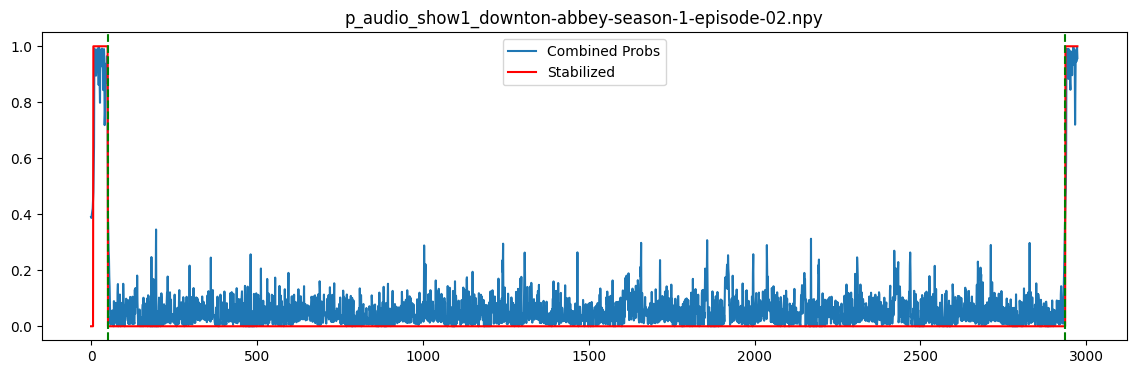

  5%|▌         | 1/19 [00:00<00:08,  2.23it/s]

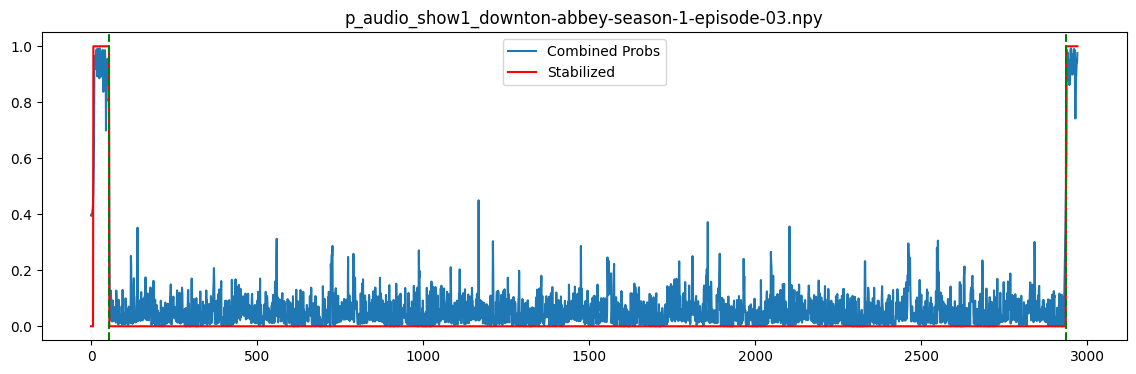

 11%|█         | 2/19 [00:00<00:05,  3.25it/s]

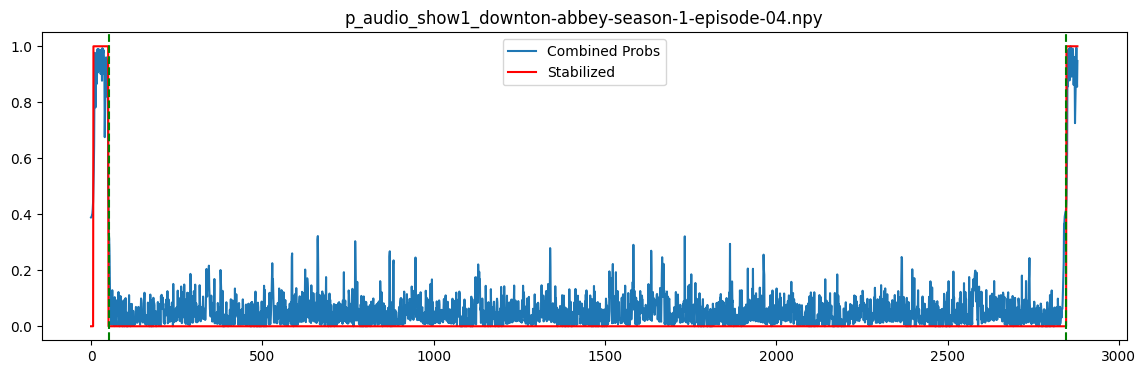

 16%|█▌        | 3/19 [00:00<00:04,  3.81it/s]

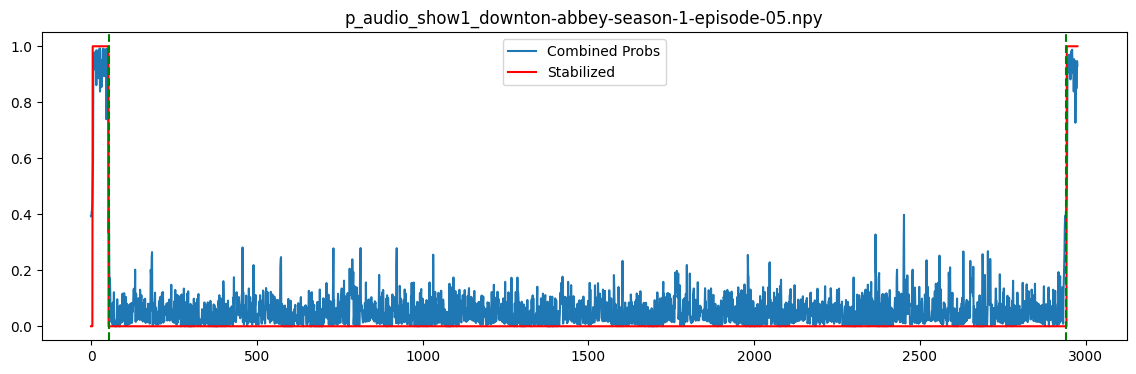

 21%|██        | 4/19 [00:01<00:03,  4.17it/s]

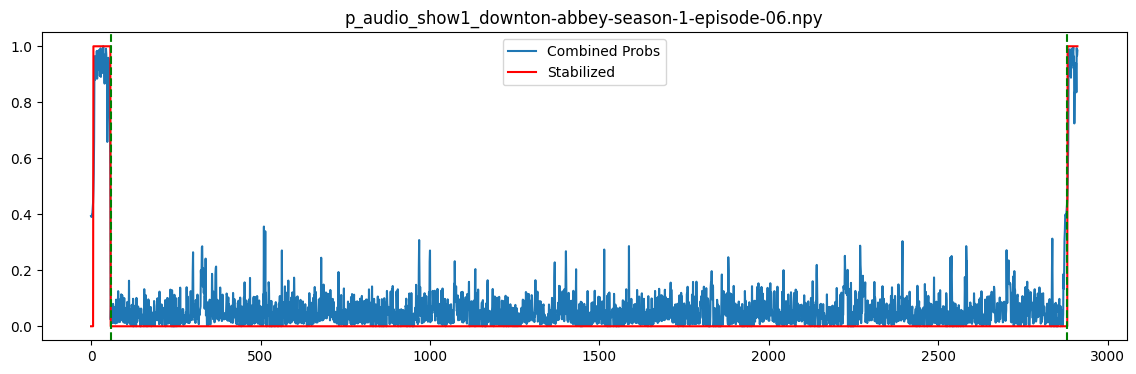

 26%|██▋       | 5/19 [00:01<00:03,  4.29it/s]

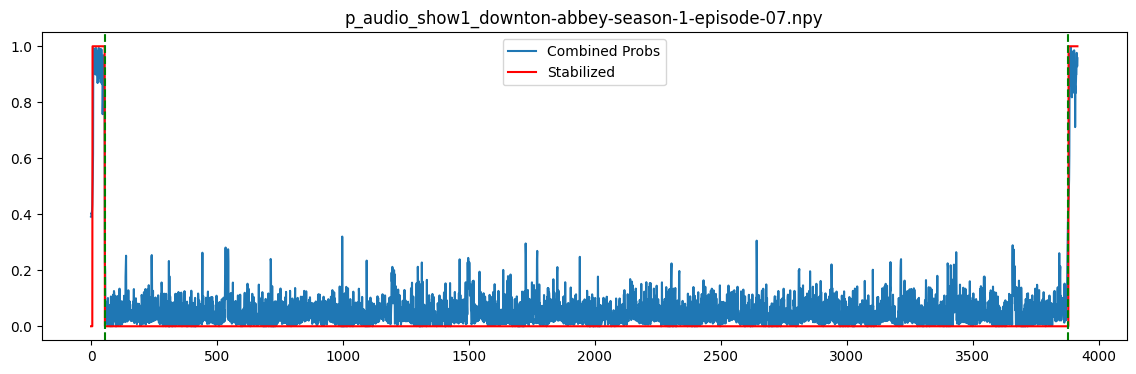

 32%|███▏      | 6/19 [00:01<00:02,  4.40it/s]

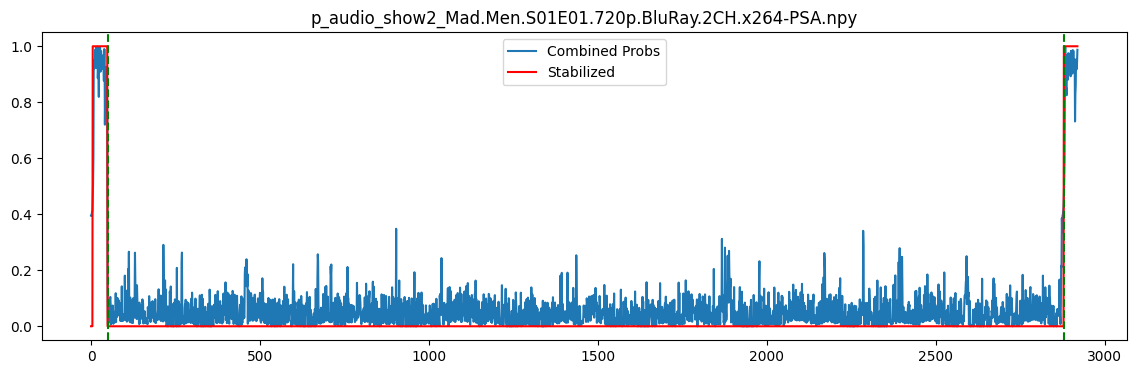

 37%|███▋      | 7/19 [00:01<00:02,  4.53it/s]

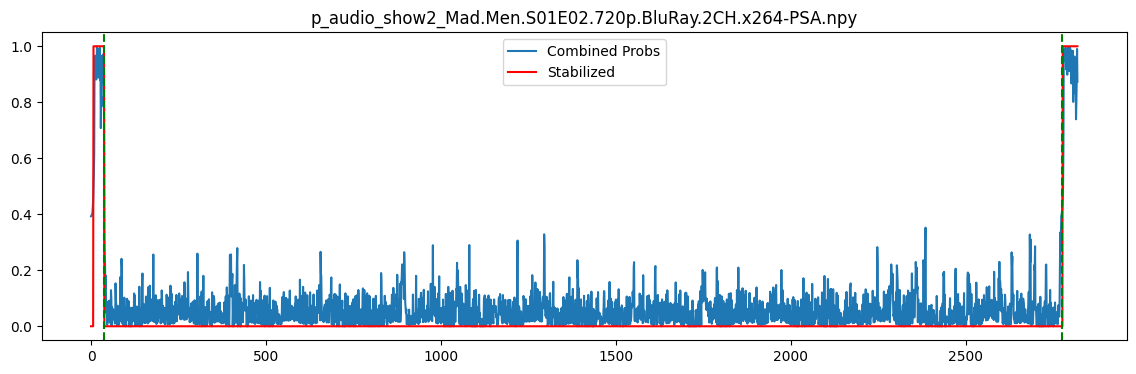

 42%|████▏     | 8/19 [00:01<00:02,  4.63it/s]

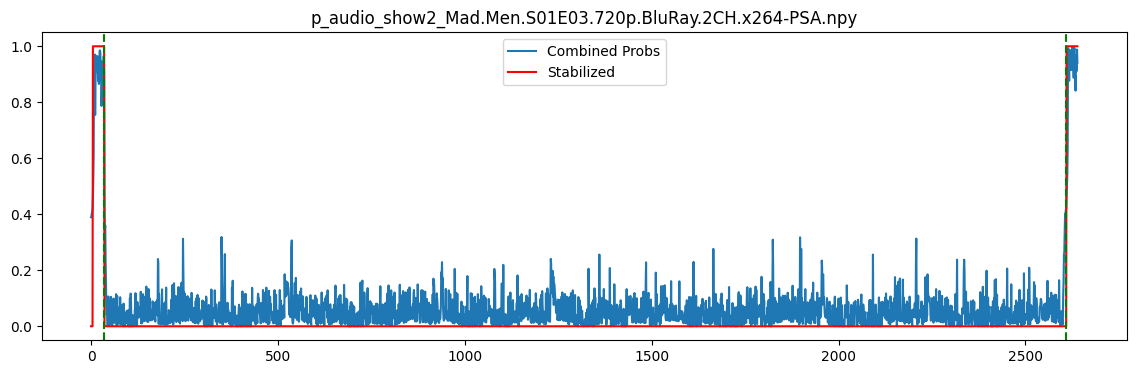

 47%|████▋     | 9/19 [00:02<00:02,  4.74it/s]

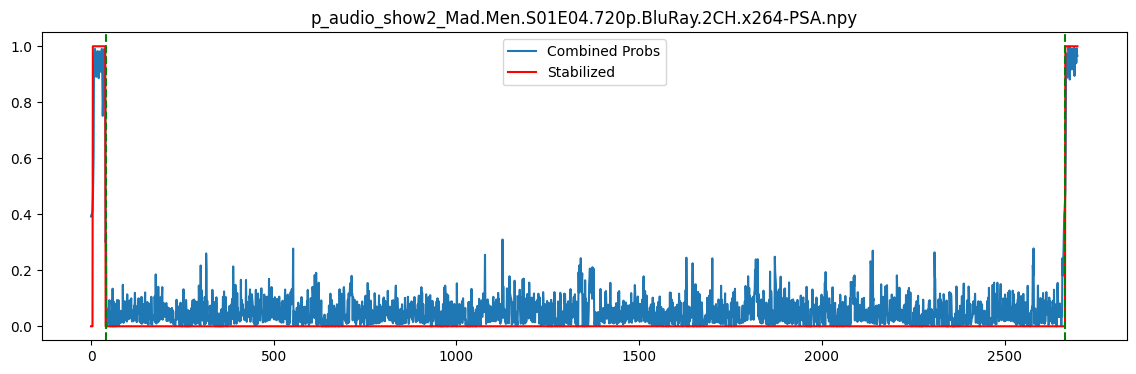

 53%|█████▎    | 10/19 [00:02<00:01,  4.86it/s]

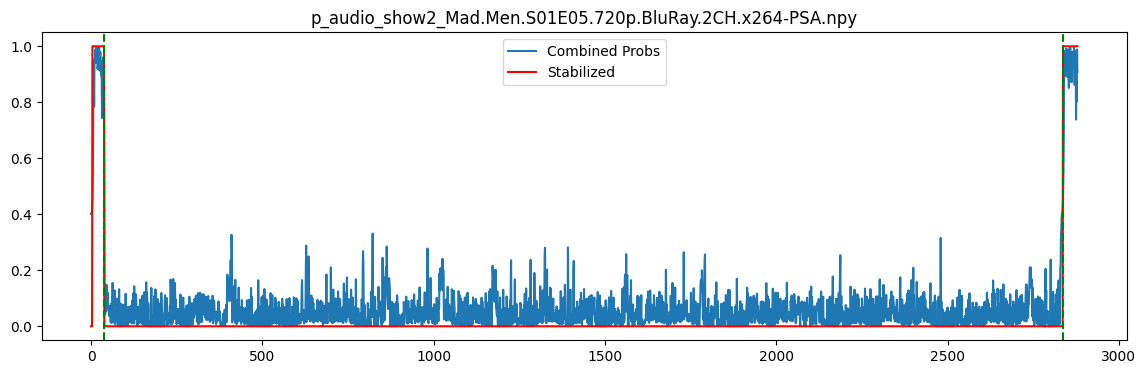

 58%|█████▊    | 11/19 [00:02<00:02,  3.42it/s]

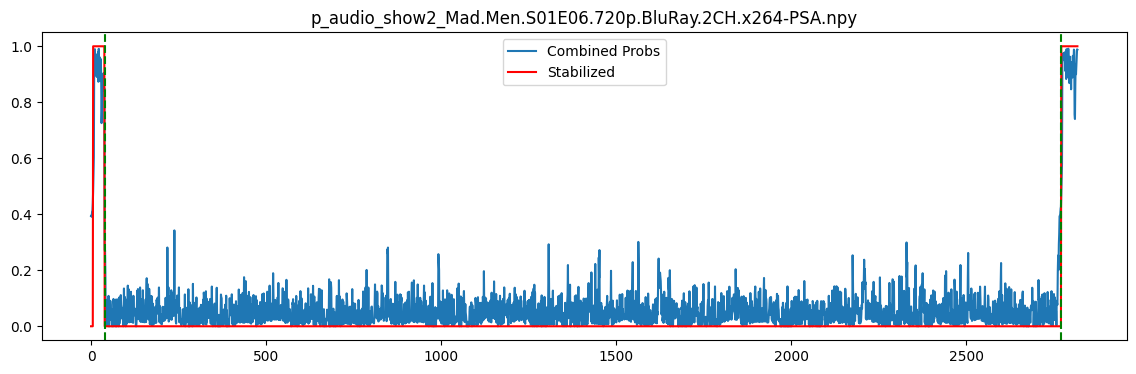

 63%|██████▎   | 12/19 [00:03<00:01,  3.70it/s]

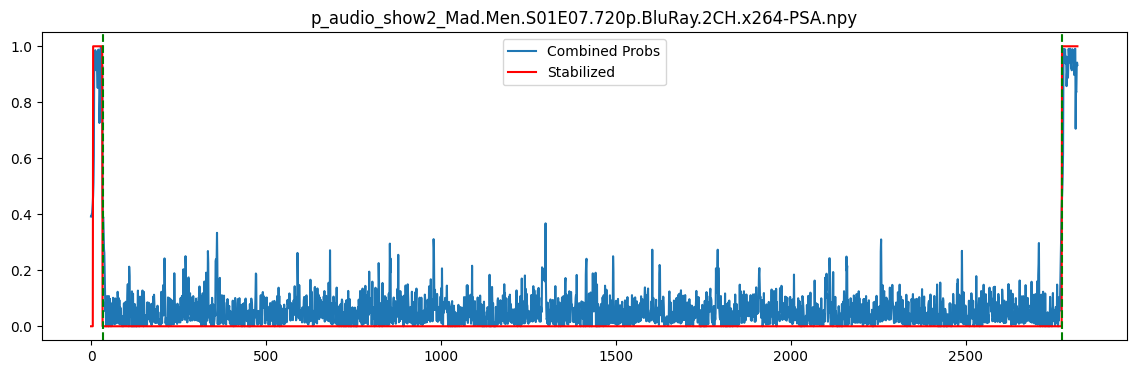

 68%|██████▊   | 13/19 [00:03<00:01,  4.01it/s]

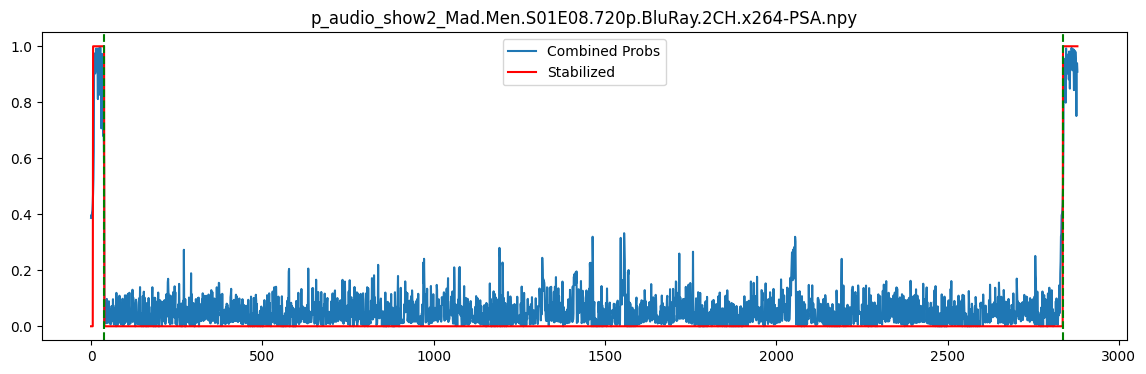

 74%|███████▎  | 14/19 [00:03<00:01,  4.20it/s]

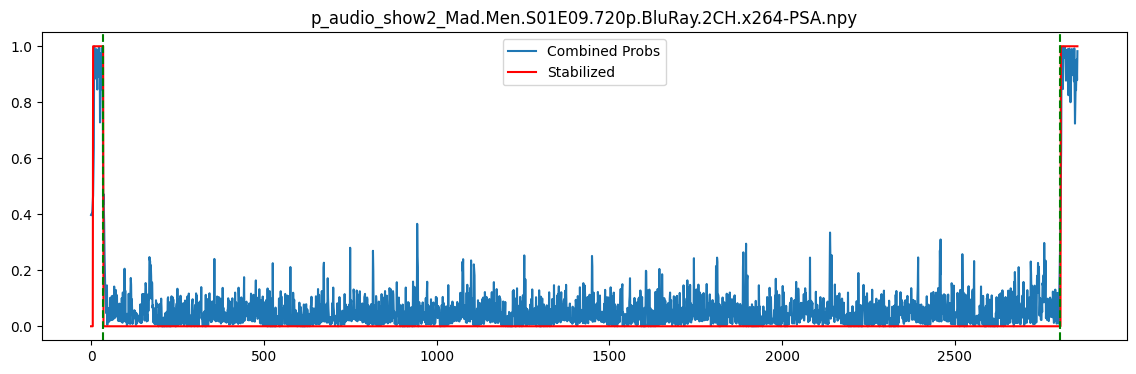

 79%|███████▉  | 15/19 [00:03<00:00,  4.35it/s]

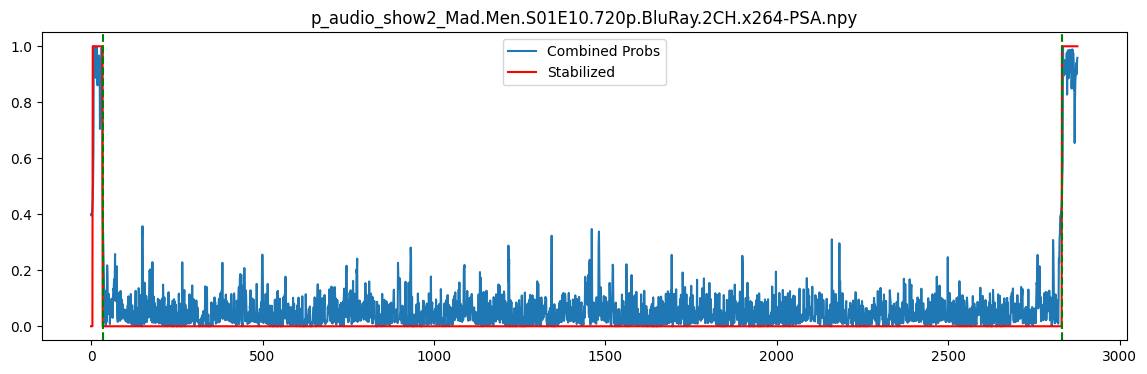

 84%|████████▍ | 16/19 [00:03<00:00,  4.38it/s]

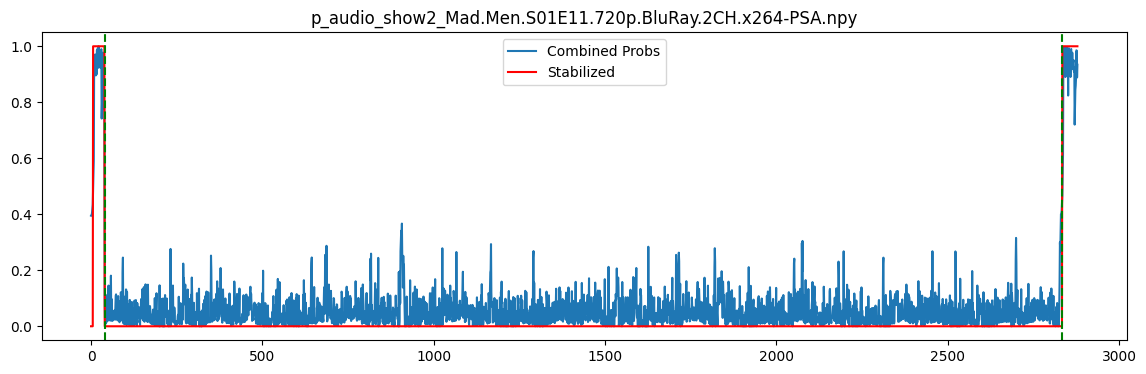

 89%|████████▉ | 17/19 [00:04<00:00,  4.54it/s]

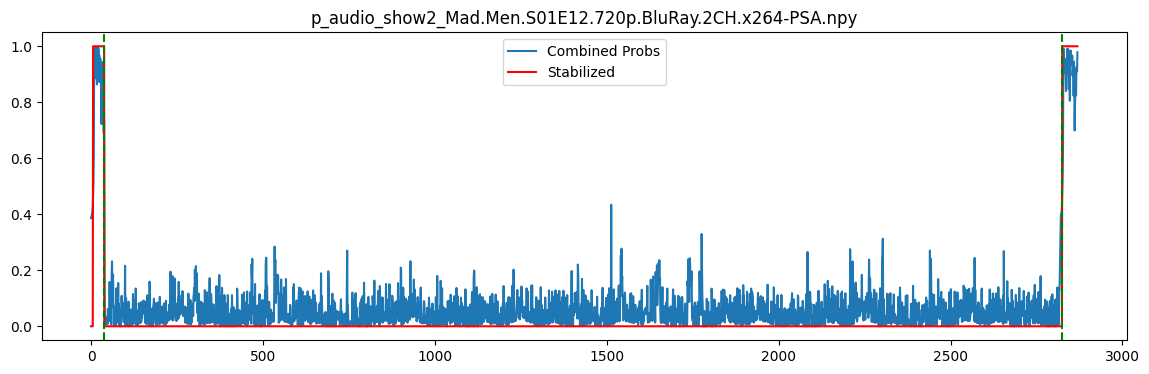

 95%|█████████▍| 18/19 [00:04<00:00,  4.64it/s]

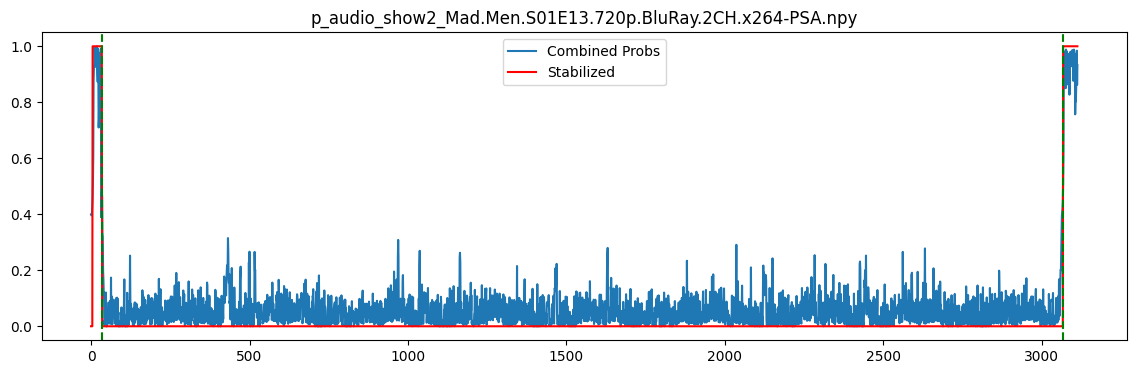

100%|██████████| 19/19 [00:04<00:00,  4.24it/s]


Результаты определения контента:
p_audio_show1_downton-abbey-season-1-episode-02.npy: 51 - 2936 (кадры)
p_audio_show1_downton-abbey-season-1-episode-03.npy: 55 - 2935 (кадры)
p_audio_show1_downton-abbey-season-1-episode-04.npy: 51 - 2846 (кадры)
p_audio_show1_downton-abbey-season-1-episode-05.npy: 53 - 2942 (кадры)
p_audio_show1_downton-abbey-season-1-episode-06.npy: 58 - 2880 (кадры)
p_audio_show1_downton-abbey-season-1-episode-07.npy: 55 - 3879 (кадры)
p_audio_show2_Mad.Men.S01E01.720p.BluRay.2CH.x264-PSA.npy: 49 - 2878 (кадры)
p_audio_show2_Mad.Men.S01E02.720p.BluRay.2CH.x264-PSA.npy: 38 - 2776 (кадры)
p_audio_show2_Mad.Men.S01E03.720p.BluRay.2CH.x264-PSA.npy: 36 - 2609 (кадры)
p_audio_show2_Mad.Men.S01E04.720p.BluRay.2CH.x264-PSA.npy: 40 - 2665 (кадры)
p_audio_show2_Mad.Men.S01E05.720p.BluRay.2CH.x264-PSA.npy: 39 - 2836 (кадры)
p_audio_show2_Mad.Men.S01E06.720p.BluRay.2CH.x264-PSA.npy: 39 - 2770 (кадры)
p_audio_show2_Mad.Men.S01E07.720p.BluRay.2CH.x264-PSA.npy: 33 - 2774 (кадры)
p

In [3]:
import numpy as np
import os
from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Параметры
AUDIO_DIR = 'data/audio_probs'
VIDEO_DIR = 'data/video_probs'
AUDIO_WEIGHT = 0.6  # Вес аудио сигнала
VIDEO_WEIGHT = 0.4  # Вес видео сигнала
THRESHOLD = 0.45    # Порог бинаризации
MIN_CONTENT_LENGTH = 600  # Минимальная длина контента (кадров)

# Собираем список файлов
audio_files = sorted([f for f in os.listdir(AUDIO_DIR) if f.endswith('.npy')])
video_files = sorted([f for f in os.listdir(VIDEO_DIR) if f.endswith('.npy')])

# Функция для извлечения признаков CRF
def extract_features(probs):
    features = []
    for i in range(len(probs)):
        feat = {
            'prob': probs[i],
            'diff': probs[i] - probs[i-1] if i > 0 else 0
        }
        features.append(feat)
    return features

# Обрабатываем каждый эпизод
results = {}
for audio_file in tqdm(audio_files):
    # Формируем имя видео файла
    video_file = audio_file.replace('p_audio_', 'p_video_')
    if video_file not in video_files:
        continue

    # Загрузка данных
    audio_probs = np.load(os.path.join(AUDIO_DIR, audio_file))
    video_probs = np.load(os.path.join(VIDEO_DIR, video_file))

    # Выравнивание по минимальной длине
    min_len = min(len(audio_probs), len(video_probs))
    audio_probs = audio_probs[:min_len]
    video_probs = video_probs[:min_len]

    # Взвешенное объединение вероятностей
    combined_probs = AUDIO_WEIGHT * audio_probs + VIDEO_WEIGHT * video_probs

    # Извлечение признаков для CRF
    X = [extract_features(combined_probs)]

    # Применение CRF (предварительно обученная модель)
    # Заглушка: в реальности требуется обучение на размеченных данных
    y_pred = [0] * len(combined_probs)  # Здесь будет реальный прогноз CRF

    # Временная стабилизация (эвристика)
    stabilized = np.convolve(
        combined_probs > THRESHOLD,
        np.ones(15),
        mode='same'
    ) > 7

    # Поиск сегментов контента (False = контент)
    diff = np.diff(stabilized.astype(int))
    starts = np.where(diff == -1)[0] + 1
    ends = np.where(diff == 1)[0]

    # Добавление границ
    if stabilized[0] == False:
        starts = np.insert(starts, 0, 0)
    if stabilized[-1] == False:
        ends = np.append(ends, len(stabilized)-1)

    # Формирование интервалов
    segments = []
    for i in range(len(starts)):
        seg_end = ends[i] if i < len(ends) else len(stabilized)-1
        segments.append((starts[i], seg_end, seg_end - starts[i] + 1))

    # Выбор основного сегмента (самый длинный)
    if segments:
        main_segment = max(segments, key=lambda x: x[2])
        if main_segment[2] > MIN_CONTENT_LENGTH:
            results[audio_file] = {
                'start_frame': main_segment[0],
                'end_frame': main_segment[1]
            }

    # Визуализация для отладки (опционально)
    plt.figure(figsize=(14, 4))
    plt.plot(combined_probs, label='Combined Probs')
    plt.plot(stabilized, 'r-', label='Stabilized')
    plt.axvline(main_segment[0], color='g', linestyle='--')
    plt.axvline(main_segment[1], color='g', linestyle='--')
    plt.title(audio_file)
    plt.legend()
    plt.show()

# Вывод результатов
print("\nРезультаты определения контента:")
for file, seg in results.items():
    print(f"{file}: {seg['start_frame']} - {seg['end_frame']} (кадры)")